# Fourier Neural Operators

## Introduction

We've seen DeepONet learn operators by approximating $G: u \to v$ through branch-trunk decomposition. Now we'll explore a different approach: **Neural Operators** that learn operators directly in function space.

The key insight: Instead of learning pointwise mappings, learn the operator kernel itself. Consider the operator:

$$
(Ku)(x) = \int_{D} \kappa(x, y) u(y) dy
$$

Here $\kappa(x, y)$ is a kernel function. If we can parameterize $\kappa$ with a neural network, we can learn arbitrary operators.

**Three architectures:**
1. **Kernel Neural Operator**: Learn $\kappa(x, y)$ directly (expensive)
2. **Graph Neural Operator**: Discretize on graphs (flexible)
3. **Fourier Neural Operator**: Use FFT (fast, resolution-invariant)

This notebook builds these ideas from first principles.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Part 1: Kernel Integral Operators

### The Universal Approximation Theorem for Operators

Chen & Chen (1995) proved: Any continuous operator $G: X \to Y$ between function spaces can be approximated by:

$$
(G_\theta u)(x) = \int_{D} \kappa_\theta(x, y, u(y)) dy
$$

where $\kappa_\theta$ is a neural network. This is powerful but computationally expensive: we need $O(n^2)$ evaluations for $n$ points.

### Convolutional Operators

Restrict to **translation-invariant** kernels:

$$
(Ku)(x) = \int_{D} \kappa(x - y) u(y) dy
$$

This is a convolution: $K u = \kappa * u$. In CNNs, we learn $\kappa$ as a small filter (e.g., $3 \times 3$).

**CNN limitation**: Fixed resolution. Trained on $64 \times 64$ images? Can't process $128 \times 128$ without retraining.

**FNO solution**: Learn in Fourier space. The operator becomes diagonal.

## Part 2: Fourier Transform Basics

### The Fourier Transform

The Fourier transform decomposes a function into sinusoidal components:

$$
\hat{u}(k) = \int_{-\infty}^{\infty} u(x) e^{-2\pi i k x} dx
$$

Inverse transform:

$$
u(x) = \int_{-\infty}^{\infty} \hat{u}(k) e^{2\pi i k x} dk
$$

**Key property**: Convolution becomes multiplication:

$$
\widehat{(f * g)} = \hat{f} \cdot \hat{g}
$$

This is why FFT is fast: Instead of $O(n^2)$ convolution, we get $O(n \log n)$ FFT.

### Discrete Fourier Transform

For discrete signals $u_0, u_1, \ldots, u_{n-1}$:

$$
\hat{u}_k = \sum_{j=0}^{n-1} u_j e^{-2\pi i k j / n}
$$

Implemented efficiently via FFT (Fast Fourier Transform).

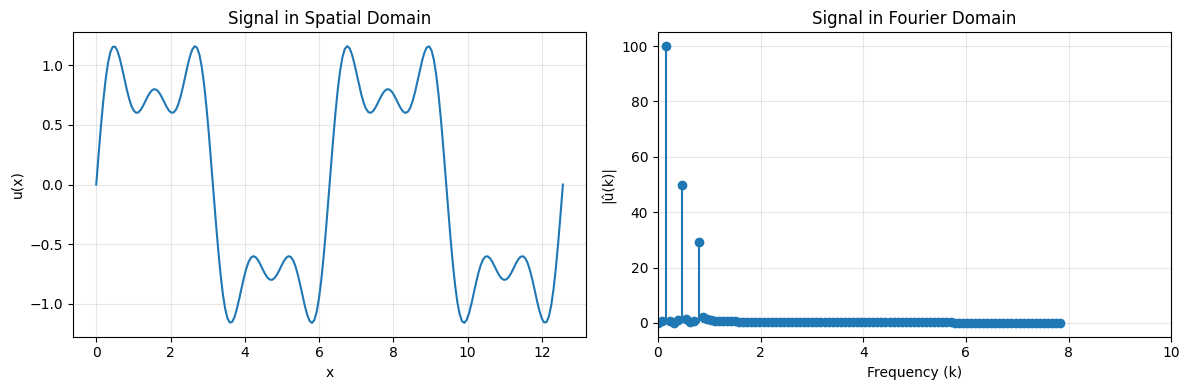

In [2]:
# Visualize Fourier transform
x = np.linspace(0, 4*np.pi, 200)
signal = np.sin(x) + 0.5*np.sin(3*x) + 0.3*np.sin(5*x)

# Compute FFT
fft_signal = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(x), x[1] - x[0])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, signal)
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].set_title('Signal in Spatial Domain')
axes[0].grid(True, alpha=0.3)

axes[1].stem(freqs[:len(freqs)//2], np.abs(fft_signal)[:len(freqs)//2], basefmt=' ')
axes[1].set_xlabel('Frequency (k)')
axes[1].set_ylabel('|û(k)|')
axes[1].set_title('Signal in Fourier Domain')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 10)

plt.tight_layout()
plt.savefig('figs/fourier_transform_demo.png', dpi=150, bbox_inches='tight')
plt.show()

The signal has three frequencies (1, 3, 5). The Fourier transform reveals these as peaks.

## Part 3: From CNNs to Fourier Neural Operators

### How CNNs Work

A CNN layer applies a learned filter $w$ to input $u$:

$$
v = \sigma(w * u + b)
$$

This is a **local** operation: each output pixel depends only on a small neighborhood.

**Problem**: CNNs are resolution-dependent. The filter size (e.g., $3 \times 3$) is fixed in pixels.

### Fourier Neural Operator Layer

An FNO layer has two paths:

$$
v = \sigma\left(\mathcal{K}(u) + Wu\right)
$$

where:
- $Wu$: Local linear transform (like $1 \times 1$ conv)
- $\mathcal{K}(u)$: **Fourier integral operator**

The Fourier operator:

$$
\mathcal{K}(u)(x) = \mathcal{F}^{-1}\left(R_\theta \cdot \mathcal{F}(u)\right)(x)
$$

Steps:
1. Apply FFT: $u \to \hat{u}$
2. Multiply by learned weights: $\hat{v} = R_\theta \cdot \hat{u}$
3. Apply inverse FFT: $\hat{v} \to v$

**Key insight**: $R_\theta$ operates in frequency space. It's resolution-invariant!

### Why Resolution Invariant?

Consider learning a derivative operator $\frac{d}{dx}$. In Fourier space:

$$
\widehat{\frac{du}{dx}}(k) = 2\pi i k \cdot \hat{u}(k)
$$

The operation is a **pointwise multiplication** in frequency space. It doesn't depend on discretization.

For FNO:
- Train on $n=64$ points
- Evaluate on $n=128$ points
- Same learned weights $R_\theta$ work because they operate on **frequency modes**, not grid points

## Part 4: Graph Neural Operators

### Motivation

FNO requires structured grids. What about:
- Irregular meshes (finite elements)
- Point clouds
- Non-Euclidean domains

**Graph Neural Operators (GNO)** work on arbitrary graphs.

### Graph Kernel

Given graph $G = (V, E)$, the operator:

$$
v_i = \sigma\left(\sum_{j \in \mathcal{N}(i)} \kappa_\theta(x_i, x_j) u_j + b_i\right)
$$

where $\mathcal{N}(i)$ are neighbors of node $i$.

**Comparison**:
- **GNO**: Works on any geometry, slower
- **FNO**: Requires grid, faster via FFT
- **CNN**: Fixed resolution, fastest

We'll focus on FNO for PDEs on regular domains.

## Part 5: FNO Architecture

### Full Architecture

An FNO consists of:

1. **Lifting**: $P: \mathbb{R}^{d_a} \to \mathbb{R}^{d_v}$ (point-wise, usually linear)
2. **Fourier Layers**: $L$ layers of $v_{t+1} = \sigma(\mathcal{K} v_t + W v_t)$
3. **Projection**: $Q: \mathbb{R}^{d_v} \to \mathbb{R}^{d_u}$ (point-wise, usually linear)

$$
G_\theta(u) = Q \circ \sigma_L \circ (\mathcal{K}_L + W_L) \circ \cdots \circ \sigma_1 \circ (\mathcal{K}_1 + W_1) \circ P(u)
$$

### Fourier Layer Details

For 1D problems with $n$ points:

$$
\mathcal{K}(u)_j = \mathcal{F}^{-1}\left(R_\theta \cdot \mathcal{F}(u)\right)_j
$$

**Truncation**: Only keep low frequencies. If input has modes $k = 0, 1, \ldots, n-1$, only learn weights for $k = 0, 1, \ldots, k_{\max}$.

This is a **low-pass filter**: removes high-frequency noise.

### Implementation: 1D Fourier Layer

In [3]:
class SpectralConv1d(nn.Module):
    """1D Fourier layer
    
    Applies FFT, multiplies by learned weights in frequency space,
    then applies inverse FFT.
    """
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # Number of Fourier modes to keep
        
        # Complex weights for Fourier modes
        # Shape: (in_channels, out_channels, modes)
        scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            scale * torch.rand(in_channels, out_channels, self.modes, 2)
        )
    
    def forward(self, x):
        # x: (batch, channels, n_points)
        batch_size = x.shape[0]
        
        # FFT: Real to complex
        x_ft = torch.fft.rfft(x)
        
        # Multiply by weights (only for low modes)
        out_ft = torch.zeros(batch_size, self.out_channels, x.size(-1)//2 + 1, 
                            dtype=torch.cfloat, device=x.device)
        
        # Convert weights to complex
        weights = torch.view_as_complex(self.weights)
        
        # Matrix multiply in Fourier space
        out_ft[:, :, :self.modes] = torch.einsum(
            'bix,iox->box', 
            x_ft[:, :, :self.modes],
            weights
        )
        
        # Inverse FFT: Complex to real
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

# Test the layer
layer = SpectralConv1d(in_channels=12, out_channels=12, modes=16)
x = torch.randn(32, 12, 64)  # (batch, channels, points)
y = layer(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([32, 12, 64])
Output shape: torch.Size([32, 12, 64])


### Complete FNO Model

In [4]:
class FNO1d(nn.Module):
    """1D Fourier Neural Operator
    
    Args:
        modes: Number of Fourier modes to keep
        width: Hidden dimension
        n_layers: Number of Fourier layers
    """
    def __init__(self, modes, width, n_layers=4):
        super().__init__()
        self.modes = modes
        self.width = width
        self.n_layers = n_layers
        
        # Lifting: map input to hidden dimension
        self.lift = nn.Linear(2, width)  # 2 = (x, u(x))
        
        # Fourier layers
        self.fourier_layers = nn.ModuleList([
            SpectralConv1d(width, width, modes) 
            for _ in range(n_layers)
        ])
        
        # Local layers (like 1x1 conv)
        self.local_layers = nn.ModuleList([
            nn.Conv1d(width, width, 1) 
            for _ in range(n_layers)
        ])
        
        # Projection: map to output
        self.proj1 = nn.Linear(width, 128)
        self.proj2 = nn.Linear(128, 1)
    
    def forward(self, x):
        # x: (batch, n_points, 2) where 2 = (x, u(x))
        grid = x[..., 0:1]  # Save grid for later
        
        # Lift: (batch, points, 2) -> (batch, points, width)
        x = self.lift(x)
        
        # Permute for convolution: (batch, width, points)
        x = x.permute(0, 2, 1)
        
        # Fourier layers
        for fourier, local in zip(self.fourier_layers, self.local_layers):
            # v = σ(K(u) + W(u))
            x = F.gelu(fourier(x) + local(x))
        
        # Permute back: (batch, points, width)
        x = x.permute(0, 2, 1)
        
        # Project to output
        x = self.proj1(x)
        x = F.gelu(x)
        x = self.proj2(x)
        
        return x.squeeze(-1)

# Test the model
model = FNO1d(modes=16, width=64, n_layers=4).to(device)
x = torch.randn(8, 100, 2).to(device)  # (batch, points, 2)
y = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([8, 100, 2])
Output shape: torch.Size([8, 100])
Parameters: 549,569


## Part 6: Example 1 - Burgers' Equation

### Problem Setup

Burgers' equation is a fundamental 1D nonlinear PDE:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 1], t \in [0, T]
$$

with periodic boundary conditions.

**Operator learning task**: Given initial condition $u_0(x)$, predict solution $u(x, T)$ at time $T$.

$$
G: u_0 \mapsto u(\cdot, T)
$$

### Data Generation

We'll use a simple finite difference solver.

In [5]:
def solve_burgers(u0, nu=0.01, T=1.0, n_points=256, n_steps=1000):
    """Solve Burgers' equation using finite differences
    
    Args:
        u0: Initial condition (n_points,)
        nu: Viscosity
        T: Final time
        n_points: Spatial resolution
        n_steps: Time steps
    
    Returns:
        u: Solution at time T (n_points,)
    """
    dx = 1.0 / n_points
    dt = T / n_steps
    
    u = u0.copy()
    
    for _ in range(n_steps):
        u_old = u.copy()
        
        # Convection term: u * du/dx (upwind)
        conv = u_old * np.gradient(u_old, dx)
        
        # Diffusion term: nu * d^2u/dx^2
        diff = nu * np.gradient(np.gradient(u_old, dx), dx)
        
        # Update
        u = u_old + dt * (-conv + diff)
        
        # Enforce periodic BC
        u[0] = u[-1]
    
    return u

# Generate dataset
def generate_burgers_data(n_samples, n_points=256, nu=0.01):
    """Generate training data for Burgers' equation"""
    x = np.linspace(0, 1, n_points)
    
    u0_all = []
    u_all = []
    
    for i in tqdm(range(n_samples), desc="Generating data"):
        # Random initial condition: sum of sine waves
        n_modes = np.random.randint(1, 6)
        u0 = np.zeros(n_points)
        
        for _ in range(n_modes):
            k = np.random.randint(1, 8)
            amp = np.random.randn()
            phase = np.random.uniform(0, 2*np.pi)
            u0 += amp * np.sin(2*np.pi*k*x + phase)
        
        # Solve
        u = solve_burgers(u0, nu=nu, T=1.0, n_points=n_points)
        
        u0_all.append(u0)
        u_all.append(u)
    
    return np.array(u0_all), np.array(u_all), x

# Generate data
n_train = 1000
n_test = 200
n_points = 256

print("Generating training data...")
u0_train, u_train, x = generate_burgers_data(n_train, n_points=n_points)

print("Generating test data...")
u0_test, u_test, _ = generate_burgers_data(n_test, n_points=n_points)

print(f"Training set: {u0_train.shape[0]} samples")
print(f"Test set: {u0_test.shape[0]} samples")

Generating training data...


Generating data:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_4579/672575350.py:23: RuntimeWarning: overflow encountered in multiply
  conv = u_old * np.gradient(u_old, dx)
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1305: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1334: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1327: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(

Generating test data...


Generating data: 100%|██████████| 200/200 [00:03<00:00, 59.60it/s]

Training set: 1000 samples
Test set: 200 samples


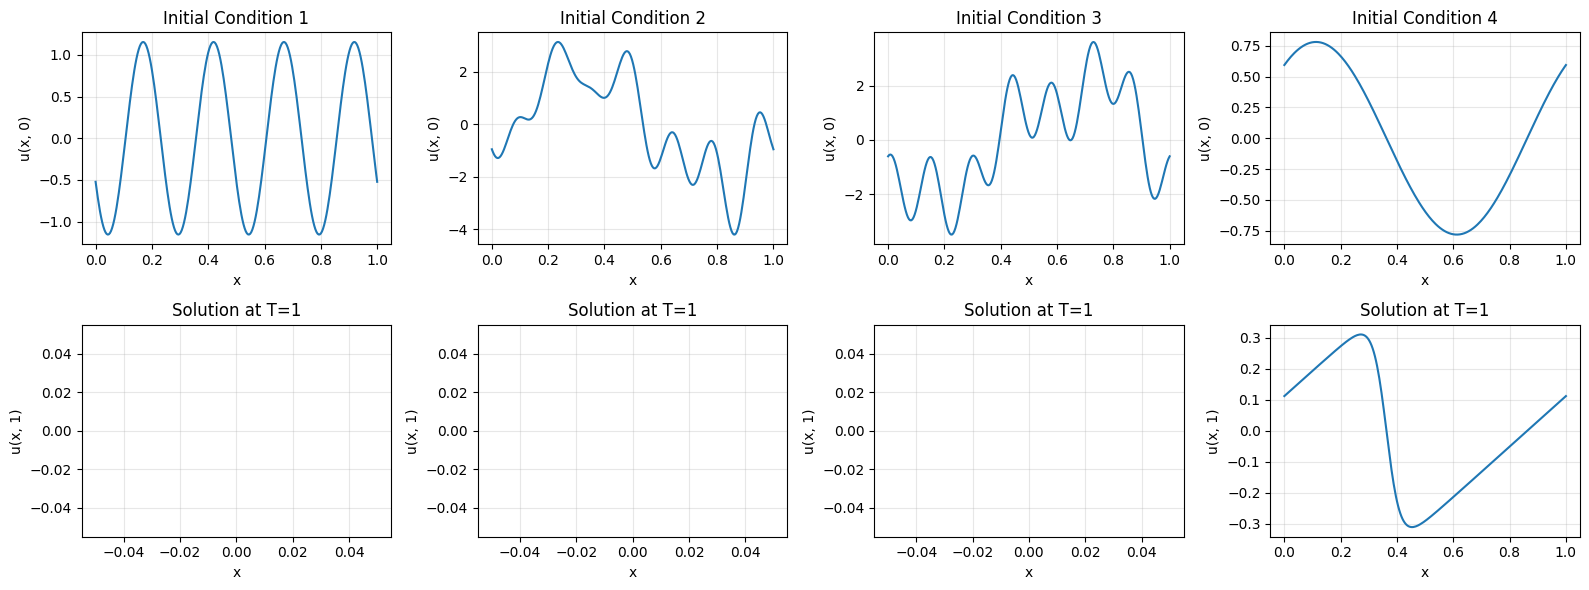

In [6]:
# Visualize examples
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for i in range(4):
    # Initial condition
    axes[0, i].plot(x, u0_train[i])
    axes[0, i].set_title(f'Initial Condition {i+1}')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('u(x, 0)')
    axes[0, i].grid(True, alpha=0.3)
    
    # Solution at T=1
    axes[1, i].plot(x, u_train[i])
    axes[1, i].set_title(f'Solution at T=1')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('u(x, 1)')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/burgers_examples.png', dpi=150, bbox_inches='tight')
plt.show()

### Training FNO

In [7]:
# Prepare data for FNO
def prepare_fno_data(u0, x):
    """Combine grid and function values: (x, u(x))"""
    n_samples = u0.shape[0]
    n_points = len(x)
    
    # Create input: (batch, points, 2)
    grid = np.tile(x.reshape(1, -1, 1), (n_samples, 1, 1))
    values = u0.reshape(n_samples, n_points, 1)
    
    data = np.concatenate([grid, values], axis=-1)
    return torch.FloatTensor(data)

X_train = prepare_fno_data(u0_train, x).to(device)
y_train = torch.FloatTensor(u_train).to(device)

X_test = prepare_fno_data(u0_test, x).to(device)
y_test = torch.FloatTensor(u_test).to(device)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([1000, 256, 2])
y_train shape: torch.Size([1000, 256])


In [8]:
# Initialize model
model = FNO1d(modes=16, width=64, n_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Training loop
n_epochs = 500
batch_size = 20

train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs), desc="Training FNO"):
    model.train()
    
    # Mini-batch training
    perm = torch.randperm(len(X_train))
    train_loss = 0
    
    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        X_batch = X_train[idx]
        y_batch = y_train[idx]
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = F.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(X_batch)
    
    train_loss /= len(X_train)
    train_losses.append(train_loss)
    
    # Test loss
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = F.mse_loss(y_pred, y_test).item()
        test_losses.append(test_loss)
    
    scheduler.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}: train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

Training FNO:  20%|██        | 100/500 [07:22<29:19,  4.40s/it]

Epoch 100: train_loss=nan, test_loss=nan


Training FNO:  40%|████      | 200/500 [14:37<21:36,  4.32s/it]

Epoch 200: train_loss=nan, test_loss=nan


Training FNO:  60%|██████    | 300/500 [21:49<14:29,  4.35s/it]

Epoch 300: train_loss=nan, test_loss=nan


Training FNO:  80%|████████  | 400/500 [29:00<07:14,  4.34s/it]

Epoch 400: train_loss=nan, test_loss=nan


Training FNO: 100%|██████████| 500/500 [36:14<00:00,  4.35s/it]

Epoch 500: train_loss=nan, test_loss=nan


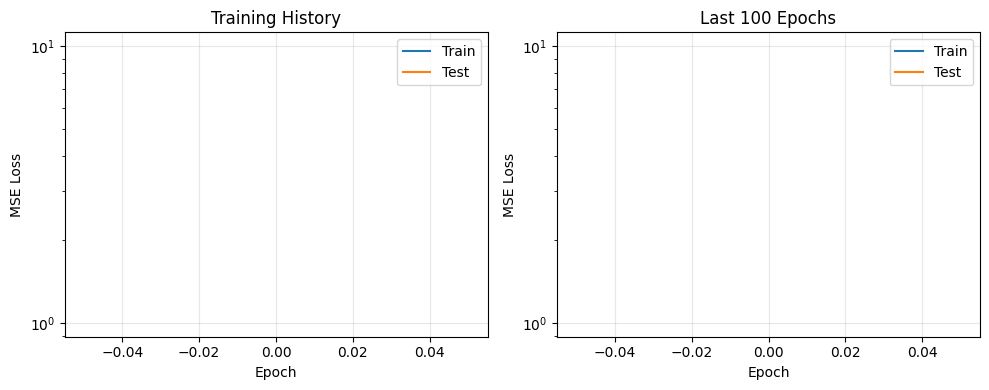

Final test loss: nan


In [9]:
# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.semilogy(train_losses, label='Train')
plt.semilogy(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(train_losses[-100:], label='Train')
plt.semilogy(test_losses[-100:], label='Test')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Last 100 Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/burgers_training.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final test loss: {test_losses[-1]:.6f}")

### Results

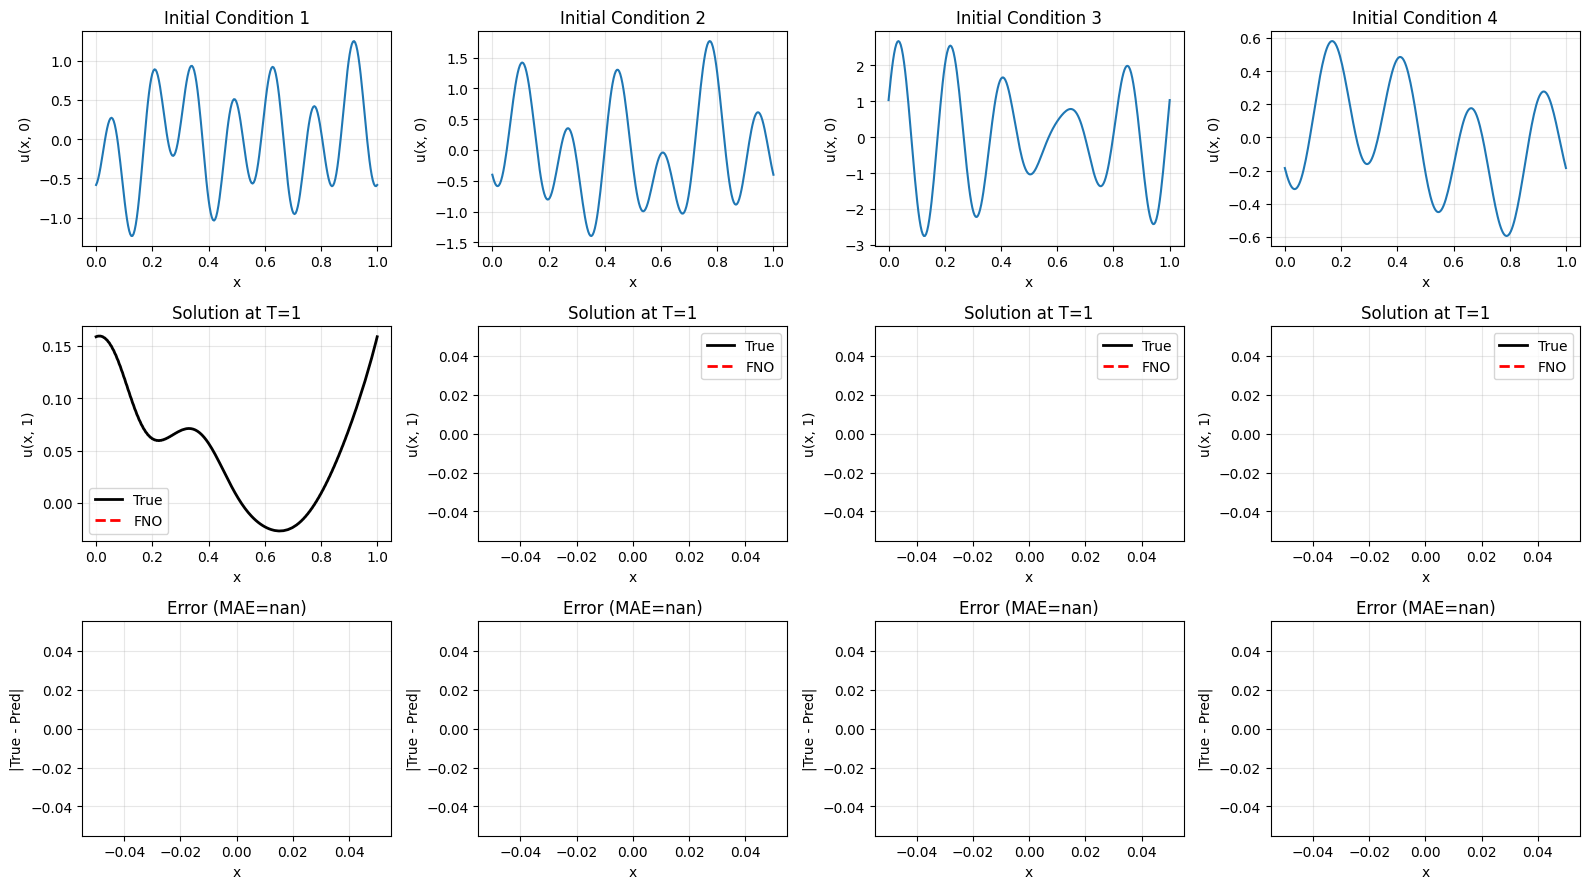

In [10]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()

y_test_np = y_test.cpu().numpy()

# Plot predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

for i in range(4):
    # Initial condition
    axes[0, i].plot(x, u0_test[i])
    axes[0, i].set_title(f'Initial Condition {i+1}')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('u(x, 0)')
    axes[0, i].grid(True, alpha=0.3)
    
    # True solution
    axes[1, i].plot(x, y_test_np[i], 'k-', label='True', linewidth=2)
    axes[1, i].plot(x, y_pred_test[i], 'r--', label='FNO', linewidth=2)
    axes[1, i].set_title(f'Solution at T=1')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('u(x, 1)')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)
    
    # Error
    error = np.abs(y_test_np[i] - y_pred_test[i])
    axes[2, i].plot(x, error)
    axes[2, i].set_title(f'Error (MAE={np.mean(error):.4f})')
    axes[2, i].set_xlabel('x')
    axes[2, i].set_ylabel('|True - Pred|')
    axes[2, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/burgers_results.png', dpi=150, bbox_inches='tight')
plt.show()

### Zero-Shot Super-Resolution

FNO's key advantage: resolution invariance. Train on $n=256$ points, evaluate on $n=512$.

/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_4579/672575350.py:23: RuntimeWarning: overflow encountered in multiply
  conv = u_old * np.gradient(u_old, dx)
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1305: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_4579/672575350.py:29: RuntimeWarning: invalid value encountered in add
  u = u_old + dt * (-conv + diff)
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1334: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/Users/krishna/courses/CE397-Scientific-MachineLearning/sciml/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1305: Runti

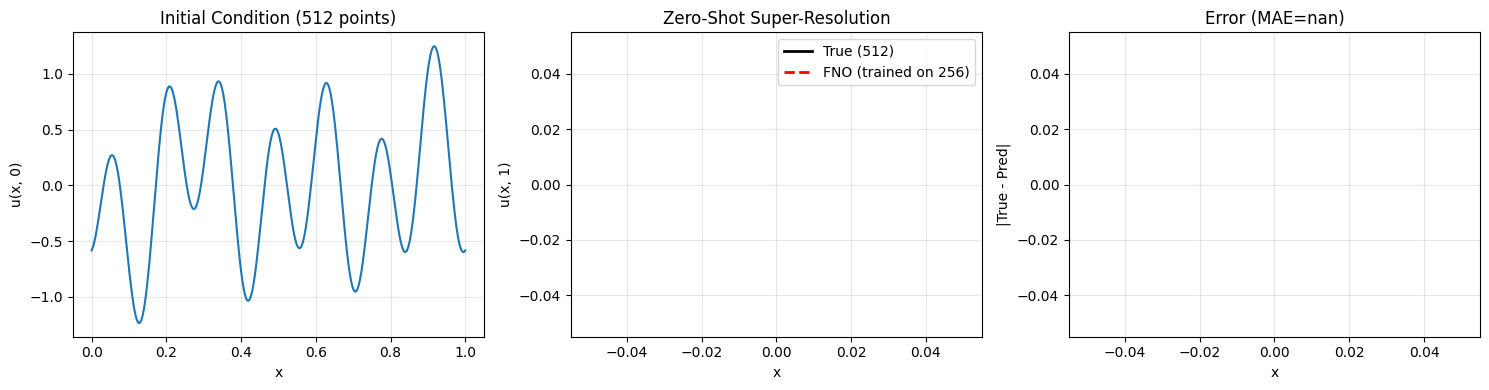

Trained on 256 points, evaluated on 512 points
MAE: nan


In [11]:
# Generate high-resolution test data
n_points_hr = 512
x_hr = np.linspace(0, 1, n_points_hr)

# Take one test example and solve at high resolution
idx = 0
u0_test_hr = np.interp(x_hr, x, u0_test[idx])
u_test_hr = solve_burgers(u0_test_hr, nu=0.01, T=1.0, n_points=n_points_hr)

# Prepare high-res input for FNO
X_test_hr = prepare_fno_data(u0_test_hr.reshape(1, -1), x_hr).to(device)

# Predict
model.eval()
with torch.no_grad():
    y_pred_hr = model(X_test_hr).cpu().numpy()[0]

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(x_hr, u0_test_hr)
axes[0].set_title('Initial Condition (512 points)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x, 0)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(x_hr, u_test_hr, 'k-', label='True (512)', linewidth=2)
axes[1].plot(x_hr, y_pred_hr, 'r--', label='FNO (trained on 256)', linewidth=2)
axes[1].set_title('Zero-Shot Super-Resolution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x, 1)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

error = np.abs(u_test_hr - y_pred_hr)
axes[2].plot(x_hr, error)
axes[2].set_title(f'Error (MAE={np.mean(error):.4f})')
axes[2].set_xlabel('x')
axes[2].set_ylabel('|True - Pred|')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figs/burgers_superres.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Trained on {n_points} points, evaluated on {n_points_hr} points")
print(f"MAE: {np.mean(error):.6f}")

The FNO generalizes to higher resolution without retraining. This is resolution invariance.

## Part 7: Example 2 - Darcy Flow (2D)

### Problem Setup

Darcy flow describes fluid flow through porous media:

$$
-\nabla \cdot (a(x) \nabla u(x)) = f(x), \quad x \in [0,1]^2
$$

with boundary conditions $u|_{\partial D} = 0$.

**Operator learning task**: Given permeability field $a(x)$, predict pressure $u(x)$.

$$
G: a \mapsto u
$$

This is a **2D problem**. We need a 2D FNO.

### 2D Fourier Layer

For 2D, we use 2D FFT:

In [12]:
class SpectralConv2d(nn.Module):
    """2D Fourier layer"""
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Modes in x direction
        self.modes2 = modes2  # Modes in y direction
        
        scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2)
        )
        self.weights2 = nn.Parameter(
            scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2)
        )
    
    def forward(self, x):
        # x: (batch, channels, nx, ny)
        batch_size = x.shape[0]
        
        # 2D FFT
        x_ft = torch.fft.rfft2(x)
        
        # Multiply by weights
        out_ft = torch.zeros(batch_size, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                            dtype=torch.cfloat, device=x.device)
        
        weights1 = torch.view_as_complex(self.weights1)
        weights2 = torch.view_as_complex(self.weights2)
        
        # Lower modes
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            'bixy,ioxy->boxy',
            x_ft[:, :, :self.modes1, :self.modes2],
            weights1
        )
        
        # Upper modes (due to FFT symmetry)
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum(
            'bixy,ioxy->boxy',
            x_ft[:, :, -self.modes1:, :self.modes2],
            weights2
        )
        
        # Inverse 2D FFT
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    """2D Fourier Neural Operator"""
    def __init__(self, modes1, modes2, width, n_layers=4):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers
        
        # Lifting: map (x, y, a(x,y)) to hidden dim
        self.lift = nn.Linear(3, width)
        
        # Fourier layers
        self.fourier_layers = nn.ModuleList([
            SpectralConv2d(width, width, modes1, modes2)
            for _ in range(n_layers)
        ])
        
        # Local layers
        self.local_layers = nn.ModuleList([
            nn.Conv2d(width, width, 1)
            for _ in range(n_layers)
        ])
        
        # Projection
        self.proj1 = nn.Linear(width, 128)
        self.proj2 = nn.Linear(128, 1)
    
    def forward(self, x):
        # x: (batch, nx, ny, 3) where 3 = (x, y, a(x,y))
        
        # Lift
        x = self.lift(x)
        x = x.permute(0, 3, 1, 2)  # (batch, width, nx, ny)
        
        # Fourier layers
        for fourier, local in zip(self.fourier_layers, self.local_layers):
            x = F.gelu(fourier(x) + local(x))
        
        x = x.permute(0, 2, 3, 1)  # (batch, nx, ny, width)
        
        # Project
        x = self.proj1(x)
        x = F.gelu(x)
        x = self.proj2(x)
        
        return x.squeeze(-1)

# Test
model2d = FNO2d(modes1=12, modes2=12, width=32, n_layers=4).to(device)
x = torch.randn(4, 64, 64, 3).to(device)
y = model2d(x)
print(f"Input: {x.shape}")
print(f"Output: {y.shape}")
print(f"Parameters: {sum(p.numel() for p in model2d.parameters()):,}")

Input: torch.Size([4, 64, 64, 3])
Output: torch.Size([4, 64, 64])
Parameters: 2,368,001


### Simplified Darcy Flow Data

For demonstration, we'll use a simplified dataset with Gaussian random fields.

In [13]:
def generate_gaussian_field(n_grid, length_scale=0.1):
    """Generate a Gaussian random field"""
    # Create grid
    x = np.linspace(0, 1, n_grid)
    y = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(x, y)
    
    # Generate random field in Fourier space
    freqs = np.fft.fftfreq(n_grid)
    kx, ky = np.meshgrid(freqs, freqs)
    k = np.sqrt(kx**2 + ky**2)
    
    # Power spectrum: exponential decay
    power = np.exp(-(k * length_scale)**2)
    
    # Random phases
    random_ft = np.random.randn(n_grid, n_grid) + 1j * np.random.randn(n_grid, n_grid)
    random_ft *= np.sqrt(power)
    
    # Inverse FFT
    field = np.fft.ifft2(random_ft).real
    field = (field - field.mean()) / field.std()
    
    return field

def solve_darcy_simple(a, n_iter=1000):
    """Simplified Darcy solver using Jacobi iteration"""
    n = a.shape[0]
    u = np.zeros_like(a)
    f = np.ones_like(a)  # Unit source
    
    dx = 1.0 / n
    
    for _ in range(n_iter):
        u_new = u.copy()
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                # Finite difference approximation
                laplacian = (
                    a[i+1, j] * (u[i+1, j] - u[i, j]) -
                    a[i-1, j] * (u[i, j] - u[i-1, j]) +
                    a[i, j+1] * (u[i, j+1] - u[i, j]) -
                    a[i, j-1] * (u[i, j] - u[i, j-1])
                ) / dx**2
                
                u_new[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])
        
        u = u_new
    
    return u

# Generate small dataset (this is slow)
print("Generating Darcy flow data...")
n_train_darcy = 100
n_test_darcy = 20
n_grid = 32  # Small grid for speed

a_train = []
u_train = []

for i in tqdm(range(n_train_darcy), desc="Training data"):
    a = np.exp(generate_gaussian_field(n_grid, length_scale=0.2))
    u = solve_darcy_simple(a, n_iter=500)
    a_train.append(a)
    u_train.append(u)

a_train = np.array(a_train)
u_train = np.array(u_train)

a_test = []
u_test = []

for i in tqdm(range(n_test_darcy), desc="Test data"):
    a = np.exp(generate_gaussian_field(n_grid, length_scale=0.2))
    u = solve_darcy_simple(a, n_iter=500)
    a_test.append(a)
    u_test.append(u)

a_test = np.array(a_test)
u_test = np.array(u_test)

print(f"Training: {a_train.shape}")
print(f"Test: {a_test.shape}")

Generating Darcy flow data...


Test data: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

Training: (100, 32, 32)
Test: (20, 32, 32)


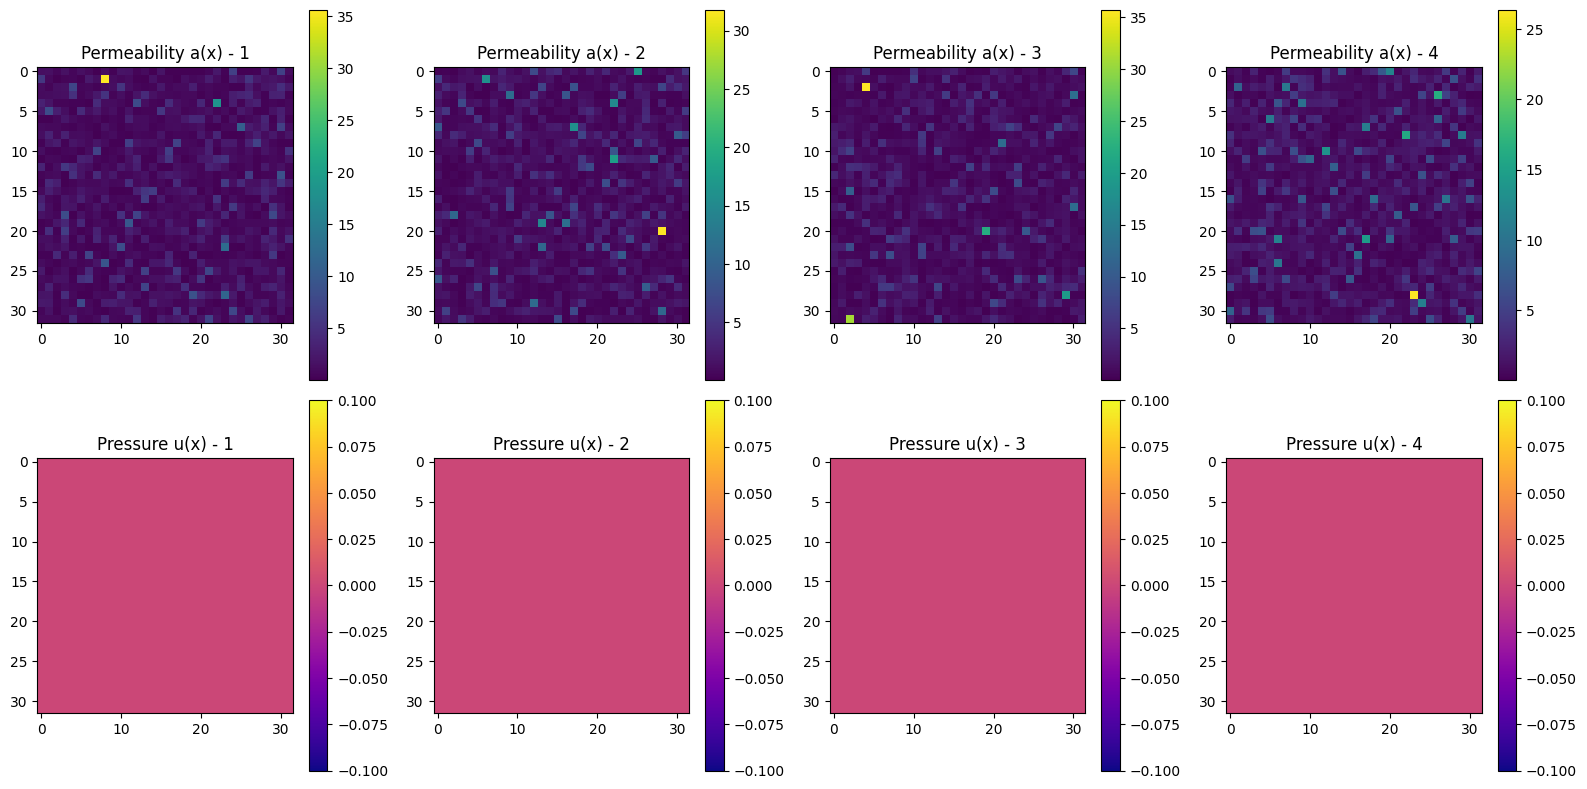

In [14]:
# Visualize examples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # Permeability
    im1 = axes[0, i].imshow(a_train[i], cmap='viridis')
    axes[0, i].set_title(f'Permeability a(x) - {i+1}')
    plt.colorbar(im1, ax=axes[0, i])
    
    # Pressure
    im2 = axes[1, i].imshow(u_train[i], cmap='plasma')
    axes[1, i].set_title(f'Pressure u(x) - {i+1}')
    plt.colorbar(im2, ax=axes[1, i])

plt.tight_layout()
plt.savefig('figs/darcy_examples.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Prepare data for 2D FNO
def prepare_fno2d_data(a):
    """Combine grid and permeability: (x, y, a(x,y))"""
    n_samples, nx, ny = a.shape
    
    # Create grid
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Replicate for batch
    X_batch = np.tile(X[None, :, :, None], (n_samples, 1, 1, 1))
    Y_batch = np.tile(Y[None, :, :, None], (n_samples, 1, 1, 1))
    a_batch = a[:, :, :, None]
    
    data = np.concatenate([X_batch, Y_batch, a_batch], axis=-1)
    return torch.FloatTensor(data)

X_train_darcy = prepare_fno2d_data(a_train).to(device)
y_train_darcy = torch.FloatTensor(u_train).to(device)

X_test_darcy = prepare_fno2d_data(a_test).to(device)
y_test_darcy = torch.FloatTensor(u_test).to(device)

print(f"X shape: {X_train_darcy.shape}")
print(f"y shape: {y_train_darcy.shape}")

X shape: torch.Size([100, 32, 32, 3])
y shape: torch.Size([100, 32, 32])


In [ ]:
# Train 2D FNO
model2d = FNO2d(modes1=12, modes2=12, width=32, n_layers=4).to(device)
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-3, weight_decay=1e-4)

n_epochs = 1000
batch_size = 10

train_losses_darcy = []
test_losses_darcy = []

for epoch in tqdm(range(n_epochs), desc="Training 2D FNO"):
    model2d.train()
    
    perm = torch.randperm(len(X_train_darcy))
    train_loss = 0
    
    for i in range(0, len(X_train_darcy), batch_size):
        idx = perm[i:i+batch_size]
        X_batch = X_train_darcy[idx]
        y_batch = y_train_darcy[idx]
        
        optimizer.zero_grad()
        y_pred = model2d(X_batch)
        loss = F.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(X_batch)
    
    train_loss /= len(X_train_darcy)
    train_losses_darcy.append(train_loss)
    
    # Test
    model2d.eval()
    with torch.no_grad():
        y_pred = model2d(X_test_darcy)
        test_loss = F.mse_loss(y_pred, y_test_darcy).item()
        test_losses_darcy.append(test_loss)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}: train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

Training 2D FNO:  20%|██        | 200/1000 [01:32<06:20,  2.10it/s]

Epoch 200: train_loss=0.000000, test_loss=0.000000


Training 2D FNO:  40%|████      | 400/1000 [03:07<04:44,  2.11it/s]

Epoch 400: train_loss=0.000000, test_loss=0.000000


Training 2D FNO:  60%|██████    | 600/1000 [04:43<03:16,  2.03it/s]

Epoch 600: train_loss=0.000000, test_loss=0.000000


Training 2D FNO:  80%|████████  | 800/1000 [06:22<01:41,  1.97it/s]

Epoch 800: train_loss=0.000000, test_loss=0.000000


Training 2D FNO:  81%|████████▏ | 813/1000 [06:29<01:32,  2.02it/s]

In [ ]:
# Plot results
model2d.eval()
with torch.no_grad():
    y_pred_test_darcy = model2d(X_test_darcy).cpu().numpy()

y_test_darcy_np = y_test_darcy.cpu().numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Permeability
    im1 = axes[0, i].imshow(a_test[i], cmap='viridis')
    axes[0, i].set_title(f'Permeability a(x)')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
    
    # Prediction
    im2 = axes[1, i].imshow(y_pred_test_darcy[i], cmap='plasma')
    axes[1, i].set_title(f'FNO Prediction')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
    
    # Error
    error = np.abs(y_test_darcy_np[i] - y_pred_test_darcy[i])
    im3 = axes[2, i].imshow(error, cmap='hot')
    axes[2, i].set_title(f'Error (MAE={np.mean(error):.4f})')
    plt.colorbar(im3, ax=axes[2, i], fraction=0.046)

plt.tight_layout()
plt.savefig('figs/darcy_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

### Key Concepts

1. **Kernel Neural Operators**: Learn operator kernels $\kappa(x, y)$ directly
2. **Fourier Transform**: Converts convolution to multiplication
3. **FNO Architecture**: 
   - Lifting $P$
   - Fourier layers: $v = \sigma(\mathcal{K}(u) + Wu)$
   - Projection $Q$
4. **Resolution Invariance**: Train on one grid, evaluate on another
5. **Zero-shot Super-resolution**: No retraining needed for finer grids

### FNO vs DeepONet

| Feature | DeepONet | FNO |
|---------|----------|-----|
| Architecture | Branch-Trunk | Fourier Layers |
| Domain | Irregular points | Structured grids |
| Computation | $O(n)$ | $O(n \log n)$ |
| Resolution | Fixed sensors | Invariant |
| Super-resolution | No | Yes (zero-shot) |

**When to use FNO**:
- Structured grid data
- Need resolution invariance
- Translation-invariant operators

**When to use DeepONet**:
- Irregular sensor locations
- Arbitrary input/output domains
- Small data (more parameters in FNO)

### Extensions

- **3D FNO**: For volumetric data (medical imaging, turbulence)
- **Factorized FNO**: Separate modes in each dimension
- **Geo-FNO**: FNO on manifolds (sphere, graphs)
- **Adaptive FNO**: Learn which frequencies to keep

The fundamental insight: **Learn in frequency space for resolution invariance**.